In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from tqdm import tqdm
import argparse
from functools import partial
from torchvision.utils import make_grid
from shell.utils.oodloss import OODSeparationLoss
from pythresh.thresholds.dsn import DSN
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

from shell.fleet.network import *
logging.basicConfig(level=logging.INFO)

In [3]:
experiment_folder = "."
# experiment_folder = "rerun_opt_heuristic_experiment_results"
experiment_name = "rerun_recv_latest_main_results"
dataset = "cifar100"
algo = "modular"

use_contrastive = False
num_trains_per_class = 64 if dataset != "cifar100" else 256
seed = 0
parallel = False
task_id = 4

In [4]:
def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
    cfg.sharing_strategy['enforce_balance'] = False 
    cfg.sharing_strategy['hash_data'] = True
    cfg.sharing_strategy['comm_freq'] = 20 
    return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

In [5]:
save_dir = get_save_dir(experiment_folder, experiment_name,
                        dataset, algo, num_trains_per_class, use_contrastive, seed)

fleet = setup_fleet(save_dir, task_id=task_id, parallel=False, modify_cfg=modify_cfg)
fleet.change_save_dir('debug_heuristic_data')

{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'cifar100', 'num_tasks': 20, 'num_classes_per_task': 5, 'with_replacement': False, 'num_trains_per_class': 256, 'num_vals_per_class': -1, 'remap_labels': True}, 'net': {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True}, 'sharing_strategy': {'name': 'heuristic_data', 'num_coms_per_round': 2, 'budget': 20, 'enforce_balance': False, 'shared_memory_size': 160, 'comm_freq': 16, 'query_task_mode': 'current', 'pre_or_post_comm': 'post', 'sync_base': False, 'remove_ood_neighbors': True, 'min_task': 0, 'hash_data': True, 'always_query_all_final': True}, 'seed': 0, 'algo': 'modular', 'job_name': 'cifar100_modular_numtrain_256', 'num_agents': 8, 'root_save_dir': 'rerun_recv_latest_main_results', 'parallel': True, 'num_init_tasks': 4, 'overwrite': Fa

INFO:root:Class sequence: [97 66 33 19 34  3 12  2 13 92 80  5 27 60 36 11  9 25 31 87 58 44 94 95
 64 61 62 86 79 98 93 51 22 59 26 37 83 73 78  1 30 55 85 47 41 20 63 43
 90 88 21 40 15 75  4  0 52 23 35 53 84 69 16 10 71 81  6 91 56 76 38 50
 57 74 49 18 24 39 48 99  8 65 89 67 54 32 42 14 68 45 96 77 46 28 72 17
 29 82  7 70]
INFO:root:task 0 :(1280, 3, 32, 32) (469, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (527, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 3 :(1280, 3, 32, 32) (532, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 4 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 5 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 6 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 7 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 8 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)


labels: [97 66 33 19 34  3 12  2 13 92 80  5 27 60 36 11  9 25 31 87 58 44 94 95
 64 61 62 86 79 98 93 51 22 59 26 37 83 73 78  1 30 55 85 47 41 20 63 43
 90 88 21 40 15 75  4  0 52 23 35 53 84 69 16 10 71 81  6 91 56 76 38 50
 57 74 49 18 24 39 48 99  8 65 89 67 54 32 42 14 68 45 96 77 46 28 72 17
 29 82  7 70]


INFO:root:task 9 :(1280, 3, 32, 32) (490, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 10 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (490, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (504, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (475, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (471, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (532, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [13 55 29 67 64 47 58 19 30 38 15 16 34 35 73 96 25 89 63  5 44 21 28 60
 80 86 36 95 83 40  2 24 37 61 62 57 53 79 27 82 65  4 22 45 78 33 32  9
 90 56 46 48  7 59 41 93 98 69 51 74 68 72 71 39

labels: [13 55 29 67 64 47 58 19 30 38 15 16 34 35 73 96 25 89 63  5 44 21 28 60
 80 86 36 95 83 40  2 24 37 61 62 57 53 79 27 82 65  4 22 45 78 33 32  9
 90 56 46 48  7 59 41 93 98 69 51 74 68 72 71 39 54 18 91 76 70 11 10 99
 77 52 87 31  6  1 84 43 85 42 12 94 26 88 17 49 75 92  8 97 66 50  0 23
 20 81 14  3]


INFO:root:task 10 :(1280, 3, 32, 32) (514, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (474, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (474, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (474, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (485, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (537, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [11 37 44 67 45 66 96  1 88  4  2 84 22 50 29 28 41 82 25  5  9 77 13 17
 48 76 93 81 73 91 14 94 24 32 75 19 71 10 55 63 58 33 83 18 21  6 26 52
 68  3 78 57 80 15 59 99 86 95 92 30  0  8 53 49 35 31 16 61 60 47 98 40
 46 34 97 56 12 74 51 43 27 70 20 90 64 36 72

labels: [11 37 44 67 45 66 96  1 88  4  2 84 22 50 29 28 41 82 25  5  9 77 13 17
 48 76 93 81 73 91 14 94 24 32 75 19 71 10 55 63 58 33 83 18 21  6 26 52
 68  3 78 57 80 15 59 99 86 95 92 30  0  8 53 49 35 31 16 61 60 47 98 40
 46 34 97 56 12 74 51 43 27 70 20 90 64 36 72 65 62 42 69  7 89 38 39 79
 85 23 87 54]


INFO:root:task 10 :(1280, 3, 32, 32) (514, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (460, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (529, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [63  2 24 65 38 56 94 61 75 55 25 96 86 32 11 64 30 67 80 27 41 52 20  0
 97 50 40 43 36 17 33 34 53 29 44 16 84 15 90 62 18 51 79 88 95 49 35 76
 59 31  8 14 68  9 71  6 73  5 66 28 72  1 13 93 60 12 78 26 98  4 46 39
  3 48 37 69 70 87 83 91 42 47 45 81 92 19 74

labels: [63  2 24 65 38 56 94 61 75 55 25 96 86 32 11 64 30 67 80 27 41 52 20  0
 97 50 40 43 36 17 33 34 53 29 44 16 84 15 90 62 18 51 79 88 95 49 35 76
 59 31  8 14 68  9 71  6 73  5 66 28 72  1 13 93 60 12 78 26 98  4 46 39
  3 48 37 69 70 87 83 91 42 47 45 81 92 19 74 89 22 10 82 23 77 85 99 58
 21 54  7 57]


INFO:root:task 10 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (490, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (504, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (555, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (471, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (455, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [ 6 30 52 18 83 48  1 71 97 53  5 31 72 49 11 40 59 27 14 75 63 41 93 74
 44  7 77 87 33 51 28 43 24 69 54 42 19 17 68  8  3 73 46 22  4 92 76 89
 78 56 61 91 50 67 45  0 36 99 79 64 96 21 29 32 98 70 88 57 39 47 12 81
 10  2 25 37 60 20 16 86  9 62 55 58 94 23 13

labels: [ 6 30 52 18 83 48  1 71 97 53  5 31 72 49 11 40 59 27 14 75 63 41 93 74
 44  7 77 87 33 51 28 43 24 69 54 42 19 17 68  8  3 73 46 22  4 92 76 89
 78 56 61 91 50 67 45  0 36 99 79 64 96 21 29 32 98 70 88 57 39 47 12 81
 10  2 25 37 60 20 16 86  9 62 55 58 94 23 13 35 90 80 34 84 15 95 82 85
 65 26 38 66]


INFO:root:task 10 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (512, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (513, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (505, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (474, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (525, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (493, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (479, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [31  6 72  5 12 20 71 70 26 66 52 42  2 47 56 86 21 33 76 16 80 98 97 79
 10 84 55  8 23 83 77 68 93 25 27 90 24 43 91 40 96 28  7 49 35 15 48 50
 18 53  0 92 58 34 95 32  9 64 11 60 73 14 39 19 51 88 99 29 13 87 41 69
 37  4  3 63 67 65 59 62 54 36 61 94 89 75 74

labels: [31  6 72  5 12 20 71 70 26 66 52 42  2 47 56 86 21 33 76 16 80 98 97 79
 10 84 55  8 23 83 77 68 93 25 27 90 24 43 91 40 96 28  7 49 35 15 48 50
 18 53  0 92 58 34 95 32  9 64 11 60 73 14 39 19 51 88 99 29 13 87 41 69
 37  4  3 63 67 65 59 62 54 36 61 94 89 75 74 30 78 46 85 22 17 81 57 44
 45 82 38  1]


INFO:root:task 10 :(1280, 3, 32, 32) (508, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (487, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (504, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (521, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (446, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (497, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (522, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [ 6 82 28 87 50 48  2  1 85 73 62 18 67 45 79 71 44 70  7 35 33 22  3 84
 14 58 24 91 83 72 59 90 41 51 43 25 29 92 63 56 46 47 26  0 39 17 34 97
 30 53 36 64 81 93 57 20 55 60 31 12 11 54  4 94 49 68 78 38 98 10 19 66
 96 37  9 69 76 13 89  8 74 23 15  5 52 61 95

labels: [ 6 82 28 87 50 48  2  1 85 73 62 18 67 45 79 71 44 70  7 35 33 22  3 84
 14 58 24 91 83 72 59 90 41 51 43 25 29 92 63 56 46 47 26  0 39 17 34 97
 30 53 36 64 81 93 57 20 55 60 31 12 11 54  4 94 49 68 78 38 98 10 19 66
 96 37  9 69 76 13 89  8 74 23 15  5 52 61 95 65 32 21 42 40 27 16 99 77
 75 88 80 86]


INFO:root:task 10 :(1280, 3, 32, 32) (480, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (524, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (517, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (484, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (471, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (472, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [66 65 15 81 88 34 41  4 33 29 76 82 38 94 85 57 86 11 95 78 77 67 53 75
 27 99 91 21 32  6 60 96 44 46 70 68 74 63 72 35 56  2 62 31 13  1 42  9
 80 58 83 25 97 17 73 16 37 71 54 52 93 48 19 47 98  7 45 14 23 18 40 64
 69  5 87 59 61 22 43 10 26 90 89  8 79 55 49

labels: [66 65 15 81 88 34 41  4 33 29 76 82 38 94 85 57 86 11 95 78 77 67 53 75
 27 99 91 21 32  6 60 96 44 46 70 68 74 63 72 35 56  2 62 31 13  1 42  9
 80 58 83 25 97 17 73 16 37 71 54 52 93 48 19 47 98  7 45 14 23 18 40 64
 69  5 87 59 61 22 43 10 26 90 89  8 79 55 49 24 20 92 50  3  0 51 30 36
 28 39 84 12]


INFO:root:task 10 :(1280, 3, 32, 32) (505, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (487, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (520, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (482, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Age

i_size 32
num_classes 5
net_cfg {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True, 'i_size': 32, 'num_classes': 5, 'num_tasks': 20, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>
Setting seed 0
Setting seed 1000
Setting seed 2000
Setting seed 3000
Setting seed 4000
Setting seed 5000
Setting seed 6000
Setting seed 7000


In [8]:
for agent in fleet.agents:
    print(agent.node_id, {t: len(r) for t, r in agent.agent.shared_replay_buffers.items()})
    # Xt, yt, _ = agent.agent.shared_replay_buffers[task_id].get_tensors()
    # for c in yt.unique():
    #     print('\t', c.item(), Xt[yt == c].shape)

0 {}
1 {}
2 {}
3 {}
4 {}
5 {}
6 {}
7 {}


In [9]:
for agent in fleet.agents:
    print(agent.node_id, agent.dataset.name, agent.dataset.class_sequence)

0 cifar100 [97 66 33 19 34  3 12  2 13 92 80  5 27 60 36 11  9 25 31 87 58 44 94 95
 64 61 62 86 79 98 93 51 22 59 26 37 83 73 78  1 30 55 85 47 41 20 63 43
 90 88 21 40 15 75  4  0 52 23 35 53 84 69 16 10 71 81  6 91 56 76 38 50
 57 74 49 18 24 39 48 99  8 65 89 67 54 32 42 14 68 45 96 77 46 28 72 17
 29 82  7 70]
1 cifar100 [13 55 29 67 64 47 58 19 30 38 15 16 34 35 73 96 25 89 63  5 44 21 28 60
 80 86 36 95 83 40  2 24 37 61 62 57 53 79 27 82 65  4 22 45 78 33 32  9
 90 56 46 48  7 59 41 93 98 69 51 74 68 72 71 39 54 18 91 76 70 11 10 99
 77 52 87 31  6  1 84 43 85 42 12 94 26 88 17 49 75 92  8 97 66 50  0 23
 20 81 14  3]
2 cifar100 [11 37 44 67 45 66 96  1 88  4  2 84 22 50 29 28 41 82 25  5  9 77 13 17
 48 76 93 81 73 91 14 94 24 32 75 19 71 10 55 63 58 33 83 18 21  6 26 52
 68  3 78 57 80 15 59 99 86 95 92 30  0  8 53 49 35 31 16 61 60 47 98 40
 46 34 97 56 12 74 51 43 27 70 20 90 64 36 72 65 62 42 69  7 89 38 39 79
 85 23 87 54]
3 cifar100 [63  2 24 65 38 56 94 61 75 55 25 96 8

In [10]:
for agent in fleet.agents:
    print(agent.node_id, {t: len(r) for t, r in agent.agent.shared_replay_buffers.items()})
    # Xt, yt, _ = agent.agent.shared_replay_buffers[task_id].get_tensors()
    # for c in yt.unique():
    #     print('\t', c.item(), Xt[yt == c].shape)

0 {}
1 {}
2 {}
3 {}
4 {}
5 {}
6 {}
7 {}


In [11]:
for _ in range(2):
    fleet.communicate(task_id=task_id, end_epoch=None, comm_freq=None, num_epochs=None,
                      final=False)
    print(len(fleet.agents[0].agent.shared_replay_buffers[task_id]))
    Xt, yt, _ = agent.agent.shared_replay_buffers[task_id].get_tensors()
    for c in yt.unique():
        print('\t', c.item(), Xt[yt == c].shape)

comm_round 0 final False mode current
69
	 0 torch.Size([10, 3, 32, 32])
	 1 torch.Size([21, 3, 32, 32])
	 2 torch.Size([7, 3, 32, 32])
	 3 torch.Size([10, 3, 32, 32])
	 4 torch.Size([20, 3, 32, 32])
comm_round 0 final False mode current
95
	 0 torch.Size([20, 3, 32, 32])
	 1 torch.Size([21, 3, 32, 32])
	 2 torch.Size([7, 3, 32, 32])
	 3 torch.Size([10, 3, 32, 32])
	 4 torch.Size([21, 3, 32, 32])


In [12]:
for agent in fleet.agents:
    print(agent.node_id, {t: len(r) for t, r in agent.agent.shared_replay_buffers.items()})
    # Xt, yt, _ = agent.agent.shared_replay_buffers[task_id].get_tensors()
    # for c in yt.unique():
    #     print('\t', c.item(), Xt[yt == c].shape)

0 {0: 0, 1: 0, 2: 0, 3: 0, 4: 95}
1 {0: 0, 1: 0, 2: 0, 3: 0, 4: 129}
2 {0: 0, 1: 0, 2: 0, 3: 0, 4: 65}
3 {0: 0, 1: 0, 2: 0, 3: 0, 4: 59}
4 {0: 0, 1: 0, 2: 0, 3: 0, 4: 114}
5 {0: 0, 1: 0, 2: 0, 3: 0, 4: 88}
6 {0: 0, 1: 0, 2: 0, 3: 0, 4: 47}
7 {0: 0, 1: 0, 2: 0, 3: 0, 4: 79}


In [15]:
agent.sharing_strategy.enforce_balance

False

In [16]:
agent = fleet.agents[0]
data = agent.get_consolidated_data()
for c in data.keys():
    print(c, get_local_label_for_task(c, task_id, agent.dataset.class_sequence,
                                      agent.dataset.num_classes_per_task),
                                      len(data[c]))

58 0 4
44 1 41
64 4 11
94 2 9
95 3 4


In [ ]:
X = data[58]
Y = torch.tensor([0] * X.size(0))
agent.agent.shared_replay_buffers[task_id].push(X, Y)

In [ ]:
Xt, yt, _ = agent.agent.shared_replay_buffers[task_id].get_tensors()

In [ ]:
yt

In [ ]:
{k: torch.cat(v, dim=0).size(0) for k, v in fleet.agents[1].available_data.items()}

In [ ]:
d = fleet.agents[0].dataset
d.class_sequence[task_id * d.num_classes_per_task : (task_id + 1) * d.num_classes_per_task]

In [ ]:
d = fleet.agents[1].dataset
d.class_sequence[task_id * d.num_classes_per_task : (task_id + 1) * d.num_classes_per_task]

In [ ]:
len(d.trainset[task_id])

In [ ]:
fleet.agents[1].dataset.class_sequence

In [ ]:
data= fleet.agents[3].available_data
# fig, ax = plt.subplots(1, len(data), figsize=(10, 10))
for i, (c, X) in enumerate(data.items()):
    X = torch.cat(X, dim=0)
    print(c, X.shape)
    # ax[i].imshow(make_grid(X).permute(1, 2, 0))

In [ ]:
for agent in fleet.agents:
    print(agent.node_id, {t: len(r) for t, r in agent.agent.shared_replay_buffers.items()})
    if len(agent.agent.shared_replay_buffers[task_id]) == 0:
        print('\t !!!NO DATA!!!!')
        continue
    Xt, yt, _ = agent.agent.shared_replay_buffers[task_id].get_tensors()
    for c in yt.unique():
        print('\t', c.item(), Xt[yt == c].shape)

tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4])


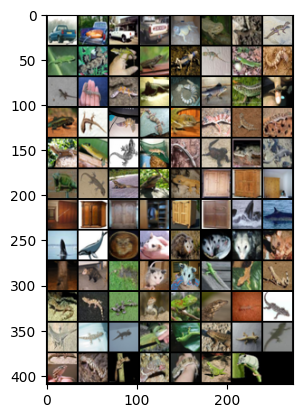

In [17]:
agent = fleet.agents[0]
Xt, yt, _ = agent.agent.shared_replay_buffers[task_id].get_tensors()

plt.imshow(make_grid(Xt).permute(1, 2, 0));
print(yt)

tensor([1, 1, 4, 0, 0, 2, 1, 1, 1, 0, 2, 3, 1, 2, 4, 2, 2, 2, 4, 2])


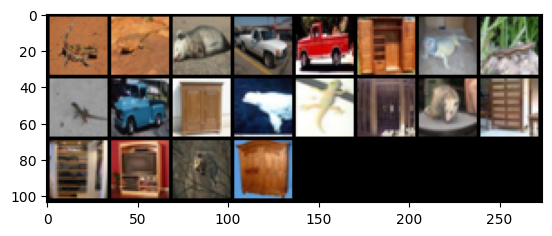

In [18]:
N = 20
Xt, yt = agent.dataset.valset[task_id].tensors

plt.imshow(make_grid(Xt[:N]).permute(1, 2, 0));
print(yt[:N])

In [ ]:
agent = fleet.agents[0]
Xt, yt, _ = agent.agent.shared_replay_buffers[task_id].get_tensors()

plt.imshow(make_grid(Xt).permute(1, 2, 0));
print(yt)